### Packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline

### Load Data

In [15]:
data_path = '../IDMT-Traffic/datasets/df_main_encoded_only.csv'  
df = pd.read_csv(data_path)
df = df.drop(columns=['file', 'Unnamed: 0', 'is_background_encoded'])
print(df.head(2))

   date_time_encoded  location_encoded  speed_kmh_encoded  daytime_encoded  \
0                  0                 0                  0                1   
1                  0                 0                  0                1   

   weather_encoded  vehicle_encoded  source_direction_encoded  \
0                0                1                         1   
1                0                1                         1   

   microphone_encoded  channel_encoded     mfcc_1  ...  band_27_dB  \
0                   0                0  55.967507  ...   37.024301   
1                   1                1  52.986820  ...   34.516289   

   band_28_dB  band_29_dB  peak_dB_1  peak_freq_1  peak_dB_2  peak_freq_2  \
0   38.508511   35.946349  50.180933    31.622777  49.528332  1000.000000   
1   34.960402   33.187933  54.903541  1000.000000  53.196406   794.328235   

   peak_dB_3  peak_freq_3  octband_dB_mean  
0  47.901831   794.328235        42.383307  
1  51.942355   501.187234        42.

### Initialize Data & Split

In [16]:
# set target
target = 'daytime_encoded'  # Zielvariable
X = df.drop(columns=[target])  # Features (alle Spalten außer 'daytime')
y = df[target]  # Zielvariable

# Train test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Ausgabe der Größen
print(f"Trainingsdaten: {X_train.shape}, Testdaten: {X_test.shape}")


# 1st split: train/ test 
#X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# 2nd split: train / validation 
#X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full)
# TRAIN 60% VAL 20% TEST 20%
#print(f"Trainingsdaten: {X_train.shape}, Validierungsdaten: {X_val.shape}, Testdaten: {X_test.shape}")
# standardize data
#scaler = StandardScaler() 
#X_filtered_scaled = scaler.fit_transform(X)

Trainingsdaten: (6552, 57), Testdaten: (2809, 57)


### Baseline Approach

In [17]:
# initialize model
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

# Train model
random_forest.fit(X_train, y_train)

# results
y_pred = random_forest.predict(X_test)

target_names = ['A', 'M']

print("Accuracy:", accuracy_score(y_test, y_pred))
print('-'*80)

print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names= target_names))
print('-'*80)

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print('-'*80)

Accuracy: 0.9558561765752936
--------------------------------------------------------------------------------

Classification Report:
               precision    recall  f1-score   support

           A       0.95      0.97      0.96      1642
           M       0.96      0.93      0.95      1167

    accuracy                           0.96      2809
   macro avg       0.96      0.95      0.95      2809
weighted avg       0.96      0.96      0.96      2809

--------------------------------------------------------------------------------

Confusion Matrix:
 [[1596   46]
 [  78 1089]]
--------------------------------------------------------------------------------


Baseline of Random Forest shows that model is suitable, accuracy value seems normal. Model can be further optimized.

## Pipeline with Scaler, Cross Validation

In [18]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Schritt 1: Standardisierung
    ('classifier', RandomForestClassifier(random_state=42))  # Schritt 2: Random Forest
])

# Cross-Validation auf den Trainingsdaten
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')

# Pipeline trainieren auf dem gesamten Training-Set
pipeline.fit(X_train, y_train)

# Vorhersagen auf den Testdaten
y_pred = pipeline.predict(X_test)

# Ergebnisse ausgeben
target_names = ['A', 'M']
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))
print("\nTestdaten-Auswertung:")
print(classification_report(y_test, y_pred, target_names= target_names))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Cross-Validation Accuracy Scores: [0.94584287 0.93897788 0.95267176 0.94580153 0.9519084 ]
Mean CV Accuracy: 0.9470404853820579

Testdaten-Auswertung:
              precision    recall  f1-score   support

           A       0.95      0.97      0.96      1642
           M       0.96      0.93      0.95      1167

    accuracy                           0.96      2809
   macro avg       0.96      0.95      0.95      2809
weighted avg       0.96      0.96      0.96      2809


Confusion Matrix:
 [[1596   46]
 [  78 1089]]


Cross validation accuracy is close to test accuracy, which indicates no overfitting.

### Learning Curve Approach

In [25]:
# Learning Curve berechnen
train_sizes, train_scores, val_scores = learning_curve(
    random_forest,             # Dein Modell
    X_train,            # Trainingsdaten
    y_train,            # Zielvariable
    cv=5,               # Anzahl der Folds für Cross-Validation
    scoring="accuracy", # Metrik zur Bewertung
    train_sizes=np.linspace(0.1, 1.0, 10),  # 10 Stufen von 10% bis 100% der Trainingsdaten
    n_jobs=-1           # Parallelisierung für schnellere Berechnung
)

# Mittelwerte und Standardabweichungen der Scores berechnen
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)


### Learning Curve Visualisation

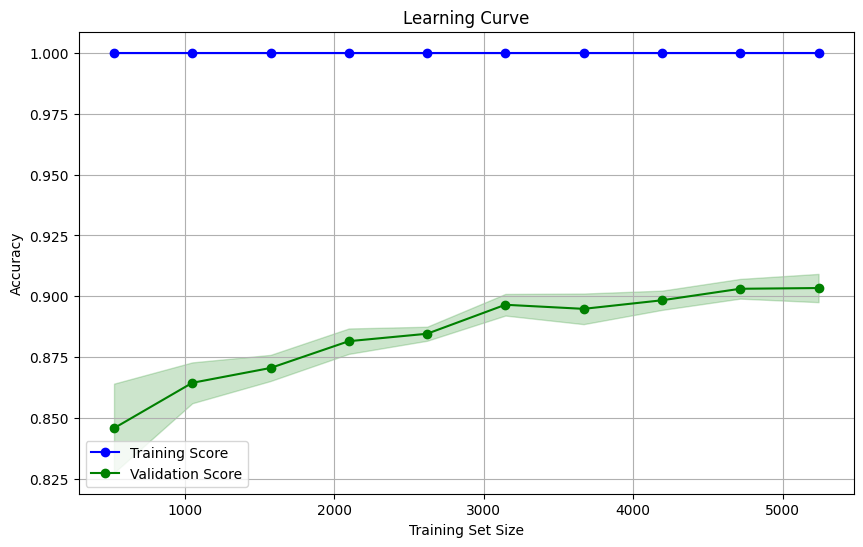

In [26]:
# Plot der Lernkurve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Training Score")
plt.plot(train_sizes, val_mean, 'o-', color="green", label="Validation Score")

# Fülle die Bereiche für Standardabweichung
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color="green")

# Plot-Konfiguration
plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid()
plt.show()


This indicates overfitting because training performance is too high. Solution is needed.

### Removal

In [23]:
data_path = '../IDMT-Traffic/datasets/df_main_encoded_only.csv'  
df_improved = pd.read_csv(data_path)
df_improved = df_improved.drop(columns=['file', 'Unnamed: 0', 'is_background_encoded']) 

# drop overpowered features
common_features = pd.read_csv("common_features.csv")
features_to_drop = common_features["Common Features"].tolist()
df_improved = df_improved.drop(columns=features_to_drop, errors="ignore")
print(df_improved.head(2))

# set target
target = 'daytime_encoded'  # Zielvariable
X = df_improved.drop(columns=[target])  # Features (alle Spalten außer 'daytime')
y = df_improved[target]  # Zielvariable

# Train test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Ausgabe der Größen
print(f"Trainingsdaten: {X_train.shape}, Testdaten: {X_test.shape}")

   location_encoded  speed_kmh_encoded  daytime_encoded  weather_encoded  \
0                 0                  0                1                0   
1                 0                  0                1                0   

   vehicle_encoded  source_direction_encoded  microphone_encoded  \
0                1                         1                   0   
1                1                         1                   1   

   channel_encoded     mfcc_1    mfcc_4  ...  band_22_dB  band_23_dB  \
0                0  55.967507  0.124549  ...   47.221654   47.465668   
1                1  52.986820 -1.037097  ...   50.465758   51.345053   

   band_24_dB  peak_dB_1  peak_freq_1  peak_dB_2  peak_freq_2  peak_dB_3  \
0   46.349888  50.180933    31.622777  49.528332  1000.000000  47.901831   
1   49.617932  54.903541  1000.000000  53.196406   794.328235  51.942355   

   peak_freq_3  octband_dB_mean  
0   794.328235        42.383307  
1   501.187234        42.050454  

[2 rows x 50 colu

In [24]:
# initialize model
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

# train model
random_forest.fit(X_train, y_train)

# results
y_pred = random_forest.predict(X_test)

target_names = ['A', 'M']

print("Accuracy:", accuracy_score(y_test, y_pred))
print('-'*80)

print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names= target_names))
print('-'*80)

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print('-'*80)

Accuracy: 0.9035243859024564
--------------------------------------------------------------------------------

Classification Report:
               precision    recall  f1-score   support

           A       0.90      0.94      0.92      1642
           M       0.91      0.86      0.88      1167

    accuracy                           0.90      2809
   macro avg       0.90      0.90      0.90      2809
weighted avg       0.90      0.90      0.90      2809

--------------------------------------------------------------------------------

Confusion Matrix:
 [[1538  104]
 [ 167 1000]]
--------------------------------------------------------------------------------
